In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tf_input):
    tf_input = tf_input*255
    tf_input = np.array(tf_input, dtype=np.uint8)
    if np.ndim(tf_input)>3:
        assert tf_input.shape[0] == 1
        tf_input = tf_input[0]
    return PIL.Image.fromarray(tf_input)


#input image of your choice
content_path = 'images/turtle.jpg'

style_path = 'images/wave.jpg'

In [2]:
def load_img(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)#Detects the image to perform apropriate opertions
    img = tf.image.convert_image_dtype(img, tf.float32)#converts image to tensor dtype

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)# Casts a tensor to float32.

    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)

    return img[tf.newaxis, :]

In [3]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

## Load the image

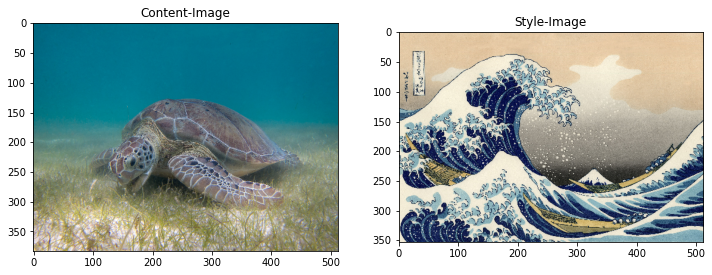

In [4]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content-Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style-Image')

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
vgg.load_weights('model/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [7]:
print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [8]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=True, weights= None)
    vgg.load_weights('model/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
    vgg.trainable = False
  
    tf_outs = [vgg.get_layer(layer).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], tf_outs)
    return model

In [10]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, tf_out in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", tf_out.numpy().shape)
    print("  min: ", tf_out.numpy().min())
    print("  max: ", tf_out.numpy().max())
    print("  mean: ", tf_out.numpy().mean())
    print()

block1_conv1
  shape:  (1, 353, 512, 64)
  min:  0.0
  max:  798.4009
  mean:  35.69268

block2_conv1
  shape:  (1, 176, 256, 128)
  min:  0.0
  max:  4381.4854
  mean:  218.17816

block3_conv1
  shape:  (1, 88, 128, 256)
  min:  0.0
  max:  9142.017
  mean:  201.35298

block4_conv1
  shape:  (1, 44, 64, 512)
  min:  0.0
  max:  24483.8
  mean:  792.31256

block5_conv1
  shape:  (1, 22, 32, 512)
  min:  0.0
  max:  3067.6594
  mean:  59.194225



In [11]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.06359174
    max:  26726.582
    mean:  792.1336

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  97692.484
    mean:  12129.934

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  260596.17
    mean:  7658.593

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3321076.5
    mean:  112238.88

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  77697.74
    mean:  728.94885

Contents:
   block5_conv2
    shape:  (1, 23, 32, 512)
    min:  0.0
    max:  950.70514
    mean:  9.476755


In [14]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [15]:
image = tf.Variable(content_image)

In [16]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [18]:
style_weight=1e-2
content_weight=1e4

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [20]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

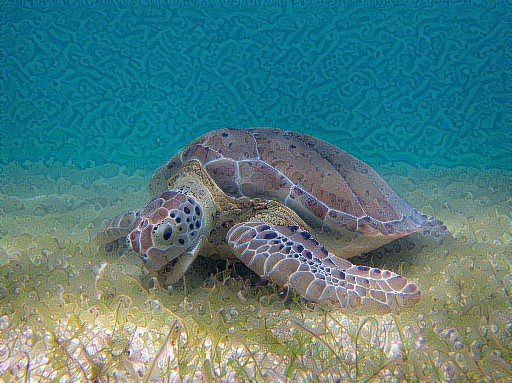

In [21]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

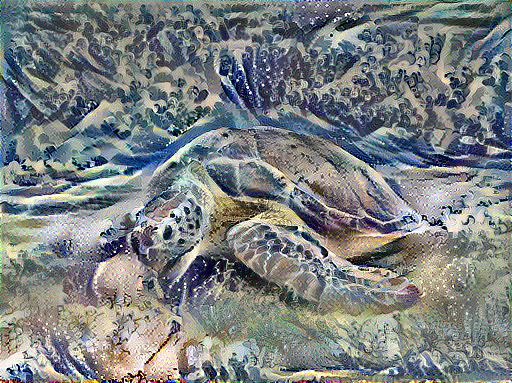

Train step: 1000
Total time: 1344.4


In [23]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [24]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

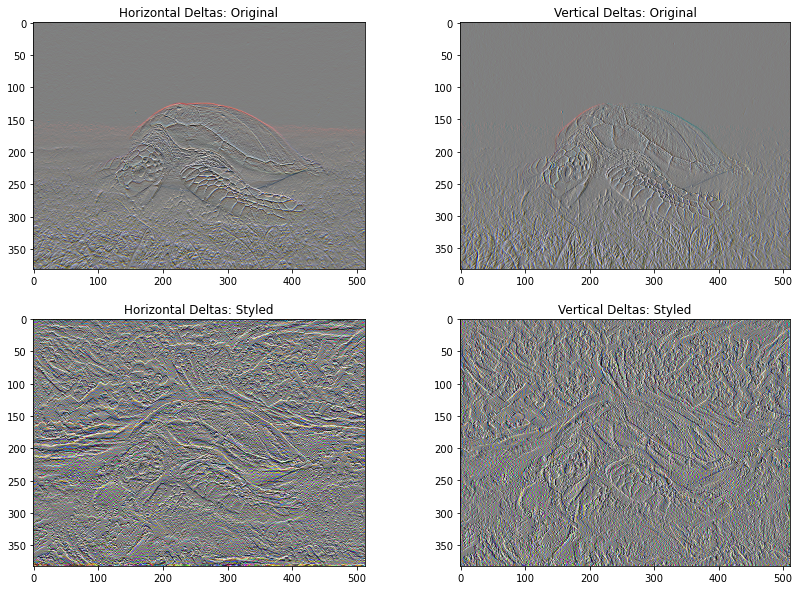

In [25]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

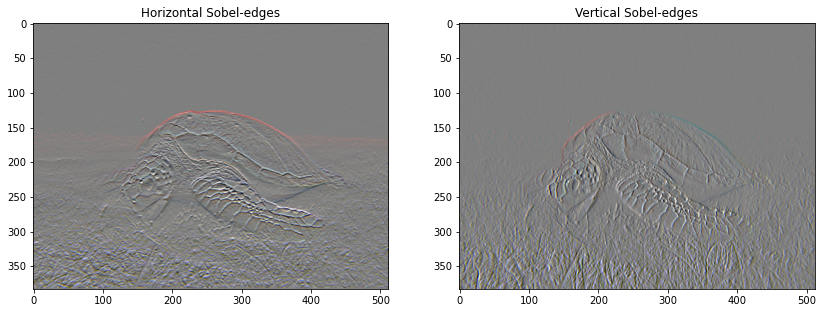

In [26]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [27]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [28]:
total_variation_loss(image).numpy()

165215.42

In [29]:
tf.image.total_variation(image).numpy()

array([165215.42], dtype=float32)

In [30]:
total_variation_weight=30

In [31]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [32]:
image = tf.Variable(content_image)

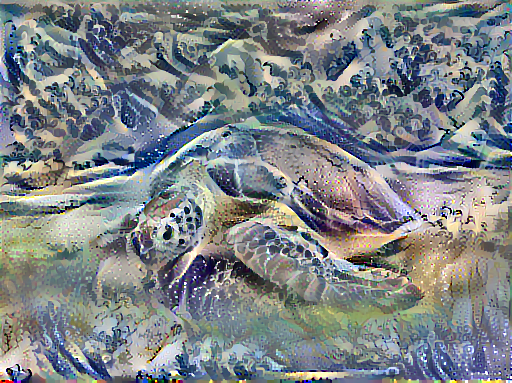

Train step: 1000
Total time: 1405.3


In [33]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

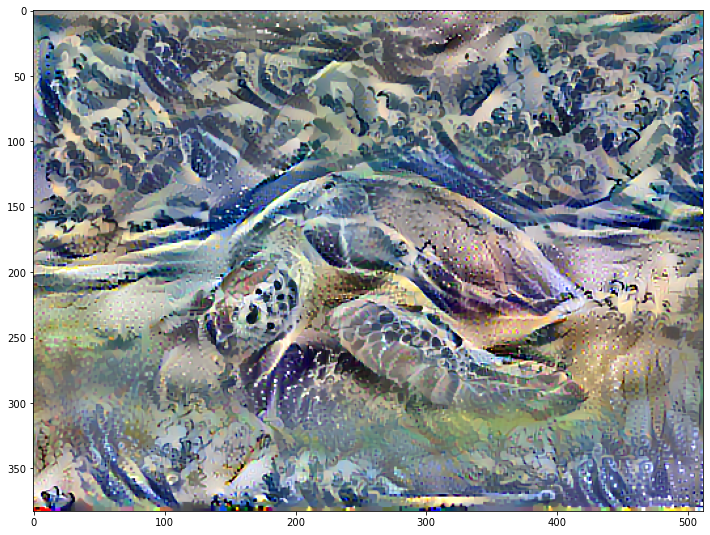

In [45]:
imshow(image)